In [1]:
import numpy as np
from scipy.linalg import solve_discrete_lyapunov
from sklearn import decomposition
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Load a dataset and pick a lag time

In [2]:
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories

from msmbuilder.featurizer import AtomPairsFeaturizer
pairs = []
for i in range(22):
    for j in range(i):
        pairs.append((j,i))
X = AtomPairsFeaturizer(pairs).fit_transform(trajs)

from msmbuilder.featurizer import DihedralFeaturizer
Y = DihedralFeaturizer().fit_transform(trajs)

lag = 1

/Users/joshuafass/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas

alanine_dipeptide already is cached


In [3]:
print(AlanineDipeptide().get().DESCR)

alanine_dipeptide already is cached
The dataset consists of ten 10ns trajectories of of alanine dipeptide,
simulated using OpenMM 6.0.1 (CUDA platform, NVIDIA GTX660) with the
AMBER99SB-ILDN force field at 300K (langevin dynamics, friction coefficient
of 91/ps, timestep of 2fs) with GBSA implicit solvent. The coordinates are
saved every 1ps. Each trajectory contains 9,999 snapshots.

The dataset, including the script used to generate the dataset
is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1026131



# 1. Whiten $X$, and split into time-lagged pairs

In [4]:
X_pca = decomposition.PCA(whiten=True)
X_pca.fit(np.vstack(X))
X_whitened = [X_pca.transform(x) for x in X]

In [5]:
X_0 = np.vstack([x[:-lag] for x in X_whitened])
X_tau = np.vstack([x[lag:] for x in X_whitened])

# 2. Estimate Koopman matrix $\mathbf{K}_{XX}$

In [6]:
K_xx_tuple = np.linalg.lstsq(X_0, X_tau)
K_xx = K_xx_tuple[0]

/Users/joshuafass/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [7]:
np.linalg.eigvalsh(K_xx).max()

1.000041

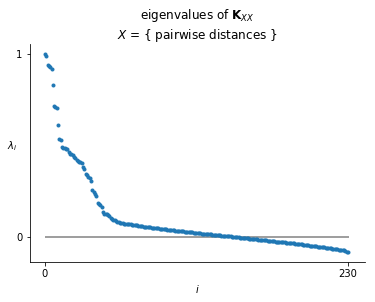

In [8]:
ax = plt.subplot(111)
plt.plot(np.linalg.eigvalsh(K_xx)[::-1], '.')
plt.title(r'eigenvalues of $\mathbf{K}_{XX}$' + '\n' + r'$X$ = $\{$ pairwise distances $\}$')
plt.xlabel(r'$i$')
plt.ylabel(r'$\lambda_i$', rotation=0)
plt.hlines(0, 0, len(K_xx), color='grey')
plt.yticks([0,1])
plt.xticks([0,230])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('K_xx_singular_values.jpg', dpi=300)

# 3. Whiten $Y$, and split into time-lagged pairs

In [9]:
Y_pca = decomposition.PCA(whiten=True)
Y_pca.fit(np.vstack(Y))
Y_whitened = [Y_pca.transform(y) for y in Y]

Y_0 = np.vstack([y[:-lag] for y in Y_whitened])
Y_tau = np.vstack([y[lag:] for y in Y_whitened])

# 4. Estimate Koopman matrix $\mathbf{K}_{XY}$

In [10]:
K_xy_tuple = np.linalg.lstsq(X_0, Y_tau)
K_xy = K_xy_tuple[0]

/Users/joshuafass/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [11]:
s = np.linalg.svd(K_xy, compute_uv=False)
s

array([0.99133164, 0.8050906 , 0.65661913, 0.3283846 ], dtype=float32)

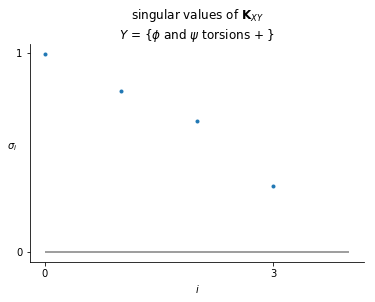

In [12]:
ax = plt.subplot(111)
plt.plot(s, '.')
plt.title(r'singular values of $\mathbf{K}_{XY}$' + '\n' + r'$Y$ = $\{ \phi$ and $\psi$ torsions + $\}$')
plt.xlabel(r'$i$')
plt.ylabel(r'$\sigma_i$', rotation=0)
plt.hlines(0, 0, len(K_xy.T), color='grey')
plt.yticks([0,1])
plt.xticks([0,3])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('K_xy_singular_values.jpg', dpi=300)

# 5. Set up the algebraic Riccati equation

In [13]:
# get v_x, the eigenvalue of K_xx corresponding to eigenvalue=1
v_x = np.linalg.eigh(K_xx)[1][-1]

In [14]:
# confirm we were indexing into the eigenvector corresponding to eigenvalue=1
np.linalg.eigh(K_xx)[0][-1]

1.000041

In [15]:
# wait what?
chi_bar = np.vstack(X_whitened).mean(0)
gamma_bar = np.vstack(Y_whitened).mean(0)
np.linalg.norm(chi_bar), np.linalg.norm(gamma_bar)
# would expect both of these to be zero mean...

(1.0000001, 0.00034046645)

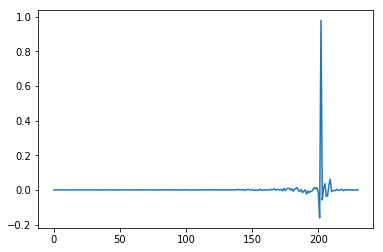

In [16]:
# weird...
plt.plot(chi_bar)

In [17]:
# take a look at this v_x, gamma_bar outer product...
np.outer(v_x, gamma_bar)

array([[ 3.96492027e-07, -2.92793175e-06, -1.46583625e-06,
        -3.91064386e-05],
       [-2.56664919e-07,  1.89536570e-06,  9.48893614e-07,
         2.53151411e-05],
       [ 1.79247564e-07, -1.32367018e-06, -6.62680634e-07,
        -1.76793837e-05],
       [-3.42458350e-07,  2.52891527e-06,  1.26607313e-06,
         3.37770398e-05],
       [ 1.07079563e-08, -7.90738852e-08, -3.95874551e-08,
        -1.05613742e-06],
       [-3.77234841e-07,  2.78572520e-06,  1.39464214e-06,
         3.72070826e-05],
       [ 7.91847441e-08, -5.84746999e-07, -2.92747046e-07,
        -7.81007748e-06],
       [ 2.19350923e-07, -1.61981700e-06, -8.10943277e-07,
        -2.16348199e-05],
       [-4.86268391e-07,  3.59089336e-06,  1.79774065e-06,
         4.79611808e-05],
       [ 2.55809937e-07, -1.88905187e-06, -9.45732722e-07,
        -2.52308128e-05],
       [ 8.71992256e-08, -6.43930719e-07, -3.22376707e-07,
        -8.60055479e-06],
       [-4.99726127e-07,  3.69027316e-06,  1.84749399e-06,
      

In [18]:
np.max(np.outer(v_x, gamma_bar)), np.min(np.outer(v_x, gamma_bar))

(6.848604e-05, -7.851491e-05)

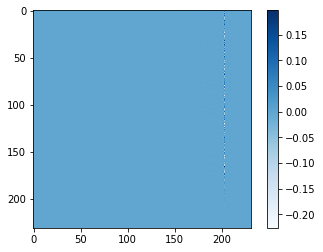

In [19]:
plt.imshow(np.outer(v_x, chi_bar), cmap='Blues')
plt.colorbar()

In [20]:
A = K_xx - np.outer(v_x, chi_bar)

In [21]:
B = K_xy - np.outer(v_x, gamma_bar)

In [22]:
# we whitened it, so this had better be pretty close to the identity matrix...
C_yy = np.vstack(Y_whitened).T.dot(np.vstack(Y_whitened))/ len(np.vstack(Y_whitened))
np.linalg.norm(C_yy - np.eye(len(C_yy)))

1.947841020069431e-05

In [23]:
Q = np.dot(B, B.T)

# 6. Solve Riccati

In [24]:
O = solve_discrete_lyapunov(A, Q)

# 7. (Truncated) SVD

In [25]:
u, s, v = np.linalg.svd(O)

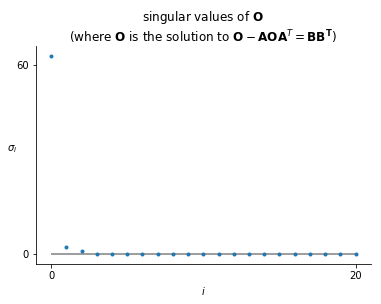

In [26]:
ax = plt.subplot(111)
plt.plot(s[:21], '.')
plt.hlines(0, 0, 20, color='grey')
plt.title('singular values of $\mathbf{O}$' + '\n(where ' + r'$\mathbf{O}$ is the solution to $\mathbf{O} - \mathbf{AOA}^T = \mathbf{BB^T}$) ')
plt.xlabel(r'$i$')
plt.ylabel(r'$\sigma_i$', rotation=0)
plt.xticks([0,20])
plt.yticks([0,60])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('O_singular_values.jpg', dpi=300)

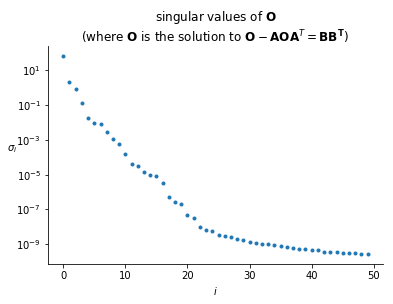

In [27]:
ax = plt.subplot(111)
plt.plot(s[:50], '.')

plt.title('singular values of $\mathbf{O}$' + '\n(where ' + r'$\mathbf{O}$ is the solution to $\mathbf{O} - \mathbf{AOA}^T = \mathbf{BB^T}$) ')
plt.yscale('log')
plt.xlabel(r'$i$')
plt.ylabel(r'$\sigma_i$', rotation=0)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('O_singular_values_log_scale.jpg', dpi=300)

# 8. Transform and inspect

In [28]:
X_transformed = np.dot(X_0, u.T)

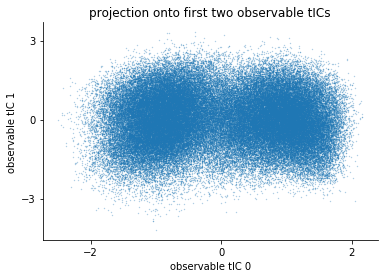

In [29]:
ax = plt.subplot(111)
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=0.1, alpha=0.5)
plt.xlabel('observable tIC 0')
plt.ylabel('observable tIC 1')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-2,0,2])
plt.yticks([-3,0,3])
plt.title('projection onto first two observable tICs')
plt.savefig('projection_onto_2d.jpg', dpi=300)

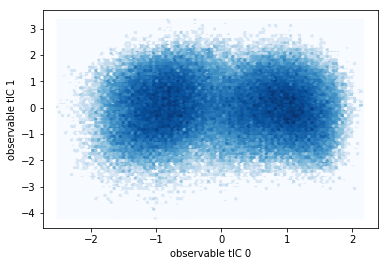

In [30]:
# log density plot
plt.hexbin(X_transformed[:,0], X_transformed[:,1], cmap='Blues', bins='log')
plt.xlabel('observable tIC 0')
plt.ylabel('observable tIC 1')

In [31]:
X_transformed_0 = np.dot(X_whitened[0], u.T)

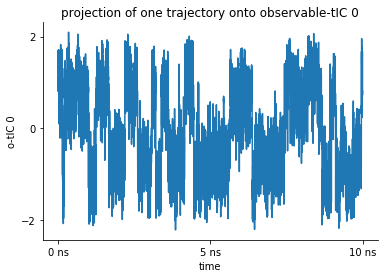

In [32]:
ax = plt.subplot(111)
plt.plot(np.arange(len(X_transformed_0)) / 1000, X_transformed_0[:,0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.yticks([-2,0,2])
plt.xticks([0,5,10], ['0 ns', '5 ns', '10 ns'])
plt.xlabel('time')
plt.ylabel('o-tIC 0')
plt.title('projection of one trajectory onto observable-tIC 0')
plt.savefig('projection_onto_1d.jpg', dpi=300)

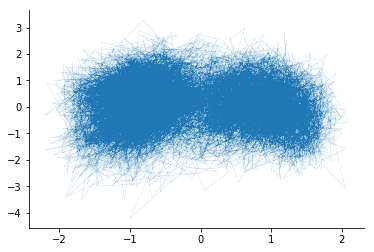

In [33]:
ax = plt.subplot(111)
plt.plot(X_transformed_0[:,0], X_transformed_0[:,1], linewidth=0.1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [34]:
# autocorrelation functions
from statsmodels.tsa.stattools import acf
n_lags = 1000

x = np.arange(n_lags + 1) / 1000 # unit: nanosecond, snapshots saved every 1ps

y0 = np.mean([acf(np.dot(x, u.T)[:,0], nlags=n_lags) for x in X_whitened], 0)
y1 = np.mean([acf(np.dot(x, u.T)[:,1], nlags=n_lags) for x in X_whitened], 0)

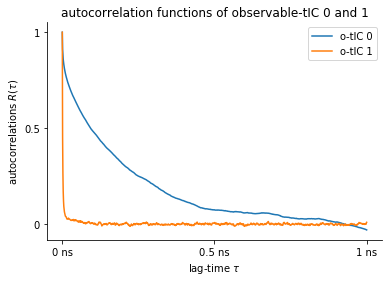

In [35]:
ax = plt.subplot(111)

plt.plot(x, y0, label='o-tIC 0')
plt.plot(x, y1, label='o-tIC 1')
#plt.ylim(0,1)
plt.yticks([0,0.5,1], ['0', '0.5', '1'])
plt.xlabel(r'lag-time $\tau$')
#plt.xlim(0,n_lags)
plt.xticks([0,0.5,1], ['0 ns', '0.5 ns', '1 ns'])

plt.ylabel(r'autocorrelations $R(\tau)$')
plt.legend(loc='best')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'autocorrelation functions of observable-tIC 0 and 1')
#plt.xscale('log')
plt.savefig('acf_linear_scale.jpg', dpi=300)

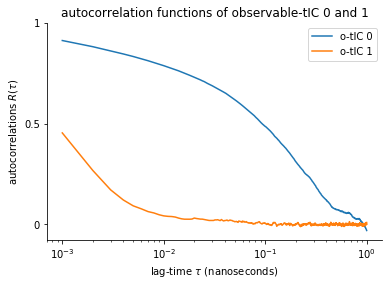

In [36]:
ax = plt.subplot(111)

plt.plot(x[1:], y0[1:], label='o-tIC 0')
plt.plot(x[1:], y1[1:], label='o-tIC 1')
#plt.ylim(0,1)
plt.yticks([0,0.5,1], ['0', '0.5', '1'])
plt.xlabel(r'lag-time $\tau$ (nanoseconds)')
#plt.xlim(0,n_lags)

plt.ylabel(r'autocorrelations $R(\tau)$')
plt.legend(loc='best')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'autocorrelation functions of observable-tIC 0 and 1')
plt.xscale('log')
plt.savefig('acf_log_scale.jpg', dpi=300)

In [37]:
# how does the o-tIC 0 compare with tIC 0 from X?
# how about with tIC 0 from Y?

from msmbuilder.decomposition import tICA
tica_X = tICA(n_components=2, lag_time=lag)
tica_X.fit(X)

tICA(commute_mapping=False, kinetic_mapping=False, lag_time=1, n_components=2,
   shrinkage=None)

In [38]:
tica_X_transformed = np.vstack(tica_X.transform(X))

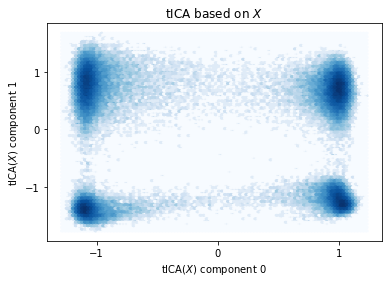

In [39]:
plt.hexbin(tica_X_transformed[:,0], tica_X_transformed[:,1], cmap='Blues',  bins='log')

plt.xticks([-1,0,1])
plt.yticks([-1,0,1])

plt.xlabel('tICA($X$) component 0')
plt.ylabel('tICA($X$) component 1')
plt.title(r'tICA based on $X$')

plt.savefig('tica(X).jpg', dpi=300)

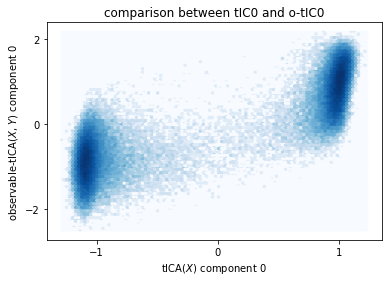

In [40]:
X_transformed = [np.dot(x, u.T) for x in X_whitened]
plt.hexbin(tica_X_transformed[:,0], np.vstack(X_transformed)[:,0], cmap='Blues',  bins='log')
plt.xlabel(r'tICA($X$) component 0')
plt.ylabel(r'observable-tICA($X$, $Y$) component 0')
plt.xticks([-1,0,1])
plt.yticks([-2,0,2])
plt.title('comparison between tIC0 and o-tIC0')

plt.savefig('tica_X_0-vs-obs_tica_0.jpg', dpi=300)

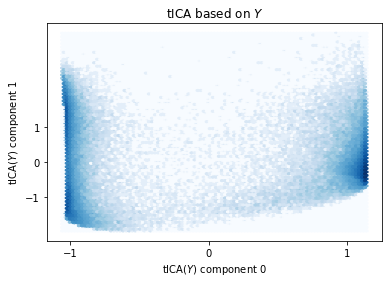

In [41]:
tica_Y = tICA(n_components=2, lag_time=lag)
tica_Y.fit(Y)
tica_Y_transformed = np.vstack(tica_Y.transform(Y))
plt.hexbin(tica_Y_transformed[:,0], tica_Y_transformed[:,1], cmap='Blues',  bins='log')

plt.xticks([-1,0,1])
plt.yticks([-1,0,1])

plt.xlabel('tICA($Y$) component 0')
plt.ylabel('tICA($Y$) component 1')
plt.title(r'tICA based on $Y$')

plt.savefig('tica(Y).jpg', dpi=300)

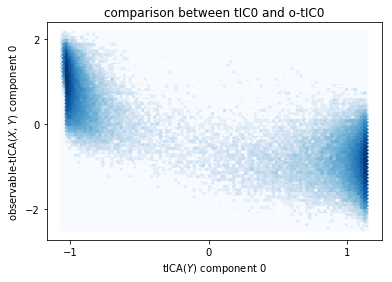

In [42]:
plt.hexbin(tica_Y_transformed[:,0], np.vstack(X_transformed)[:,0], cmap='Blues',  bins='log')
plt.xlabel(r'tICA($Y$) component 0')
plt.ylabel(r'observable-tICA($X$, $Y$) component 0')
plt.xticks([-1,0,1])
plt.yticks([-2,0,2])
plt.title('comparison between tIC0 and o-tIC0')

plt.savefig('tica_Y_0-vs-obs_tica_0.jpg', dpi=300)